In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# DATA WRANGLING & CLEANING

First we'll load the data associated with the average working hours by country

In [2]:
hrs_work = pd.read_csv('hours_worked.csv')
hrs_work = hrs_work[['LOCATION','TIME','Value','SUBJECT']]
hrs_work = hrs_work.query('SUBJECT =="TOT" and TIME == 2020 or TIME ==2019 or TIME ==2018 or TIME ==2017')
hrs_work.head()

,LOCATION,TIME,Value,SUBJECT
32,AUS,2017,1738.0,TOT
33,AUS,2018,1733.0,TOT
34,AUS,2019,1722.0,TOT
35,AUS,2020,1683.0,TOT
58,AUT,2017,1498.0,TOT


Then we'll add the data associated with the GDP and merge them together

In [3]:
gdp_hrs = pd.read_csv('gdp_hrs.csv')
gdp_hrs = gdp_hrs[['LOCATION','Country','TIME','Subject','Value','MEASURE','Measure']]
gdp_hrs = gdp_hrs.query('TIME == 2020 or TIME == 2019 or TIME ==2018 or TIME ==2017')
gdp_hrs['GDP'] = gdp_hrs.query('Subject == "Gross Domestic Product (GDP); millions"')['Value']
gdp_hrs.drop('Subject',axis =1,inplace=True)
gdp_hrs.drop('Value',axis =1,inplace=True)
df = gdp_hrs.query('Measure == "USD, current prices, current PPPs"')[['LOCATION','Country','TIME','GDP']]
df.dropna(inplace=True)
df = pd.merge(df,hrs_work,how='inner',on=['LOCATION','TIME'])
df.drop('SUBJECT',axis=1,inplace=True)
df = df.rename(columns = {'Value' : 'Hours' , 'TIME' : 'Year'})
df.head()

,LOCATION,Country,Year,GDP,Hours
0,AUS,Australia,2017,1251095.561,1738.0
1,AUS,Australia,2018,1326164.114,1733.0
2,AUS,Australia,2019,1346385.112,1722.0
3,AUS,Australia,2020,1329644.452,1683.0
4,AUT,Austria,2017,476563.995,1498.0


Then We'll load the data associated with the unemployment rate and merge it with the rest.

In [4]:
emp = pd.read_csv('unemployment.csv')
emp = emp.query("MEASURE =='PC_LF' and FREQUENCY =='A' and TIME =='2020' or TIME =='2019' or TIME == '2018' or TIME =='2017'")
emp = emp.query("SUBJECT =='TOT'")
emp = emp[['LOCATION', 'TIME', 'Value']]
emp = emp.rename(columns = {'TIME':'Year','Value':'Unemployment'})
emp['Year'] = pd.to_numeric(emp['Year'])
df = pd.merge(df,emp,how='inner',on=['LOCATION','Year'])
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
df= df.query('Country != "OECD - Total"')
df.head()

C:\Users\Ahmed\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,LOCATION,Country,Year,GDP,Hours,Unemployment
0,AUS,Australia,2017,1251095.561,1738.0,5.593760
1,AUS,Australia,2018,1326164.114,1733.0,5.299855
2,AUS,Australia,2019,1346385.112,1722.0,5.159017
3,AUS,Australia,2020,1329644.452,1683.0,6.464408
4,AUT,Austria,2017,476563.995,1498.0,5.925000


Then finally the data about the average wage.

In [5]:
wage = pd.read_csv('wage.csv')
wage = wage[['LOCATION','TIME','Value']]
wage = wage.query('TIME == 2017 or TIME == 2018 or TIME == 2019 or TIME ==2020')
wage = wage.rename(columns = {'TIME':'Year','Value':'Average_Wage'})
wage.head()
df = pd.merge(df,wage,how='inner',on=['LOCATION','Year'])
df.head()

,LOCATION,Country,Year,GDP,Hours,Unemployment,Average_Wage
0,AUS,Australia,2017,1251095.561,1738.0,5.593760,53437.058754
1,AUS,Australia,2018,1326164.114,1733.0,5.299855,53514.827225
2,AUS,Australia,2019,1346385.112,1722.0,5.159017,54020.791491
3,AUS,Australia,2020,1329644.452,1683.0,6.464408,55206.393664
4,AUT,Austria,2017,476563.995,1498.0,5.925000,53136.352960


# Exploring The Data

In [6]:
base_color = sb.color_palette()[0]

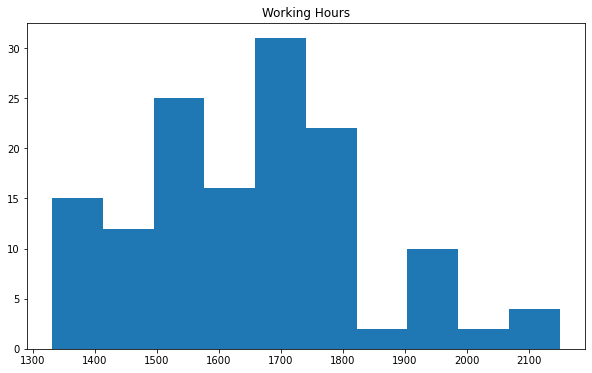

In [7]:
plt.figure(figsize=(10,6))
plt.hist(data=df,x='Hours');
plt.xlabel = 'Hours';
plt.title('Working Hours');

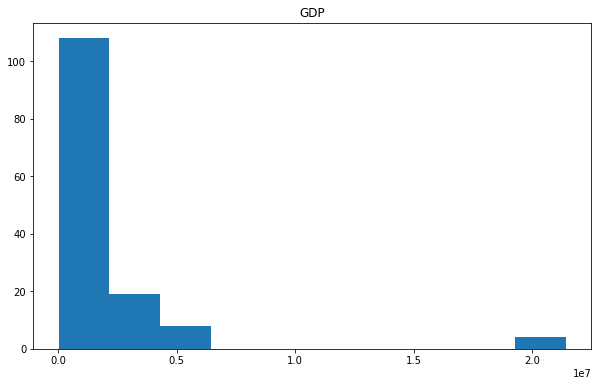

In [15]:
plt.figure(figsize=(10,6))
plt.hist(data=df,x='GDP');
plt.title('GDP');
plt.xlabel = 'GDP (in Millions)'

It's very clear that there's an oulier in the total GDP that needs more investigation to understand

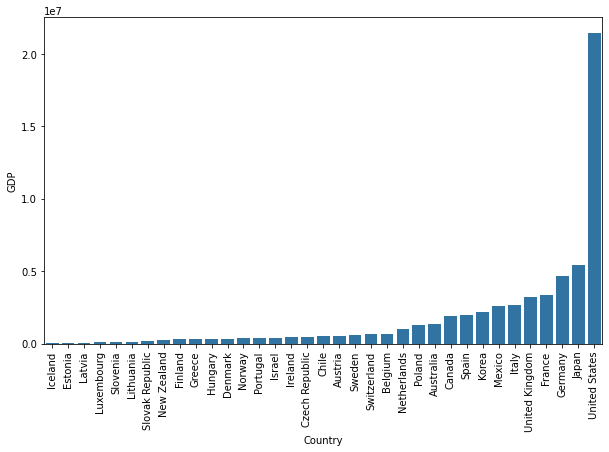

In [17]:
x = df.query('Year ==2019');
plt.figure(figsize=(10,6));
sb.barplot(data=x,x='Country',y='GDP',order=x.sort_values('GDP').Country,color=base_color);
plt.xticks(rotation=90);

Here we can see it very clear that US is the outlier and we can't ignore it we actually need to investigate it further.
Let's look at the unemployment first and its relationship with the GDP

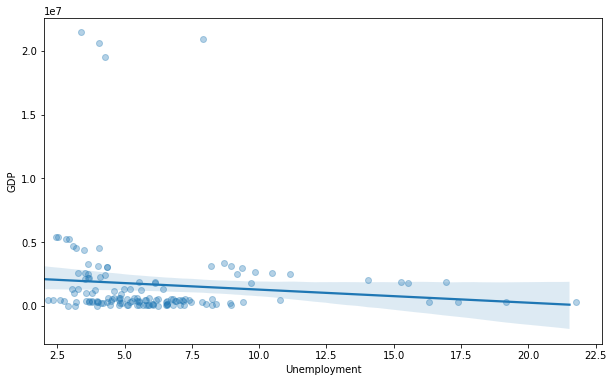

In [20]:
plt.figure(figsize=(10,6));
sb.regplot(data=df,y='GDP',x='Unemployment',x_jitter=0.3,scatter_kws={'alpha' :1/3});

Here as expected the GDP has negative correlation with the unemployment which means that as unemployment increases, the GDP decreases. Well now let's look at the countries and the unemployment rates.

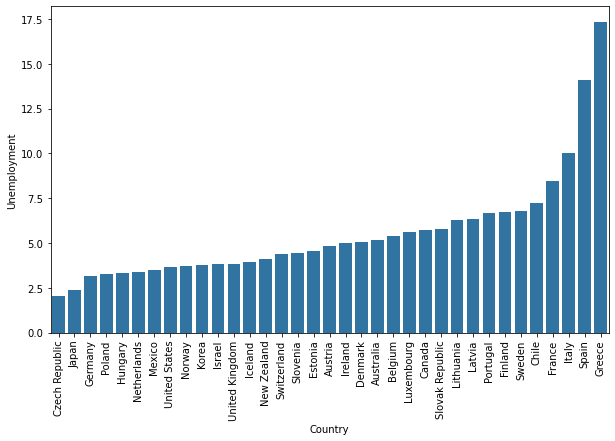

In [21]:
x = df.query('Year ==2019');
plt.figure(figsize=(10,6));
sb.barplot(data=x,x='Country',y='Unemployment',order=x.sort_values('Unemployment').Country,color=base_color);
plt.xticks(rotation=90);

From that distribution we can notice 3 points, the US which had the highest GDP by far, has a low unemployment rate but not the lowest at the same time, Greece has the highest unemployment rate with a very low GDP which makes sense but Spain is the second most unemployment rate but has an okay GDP so let's investigate more

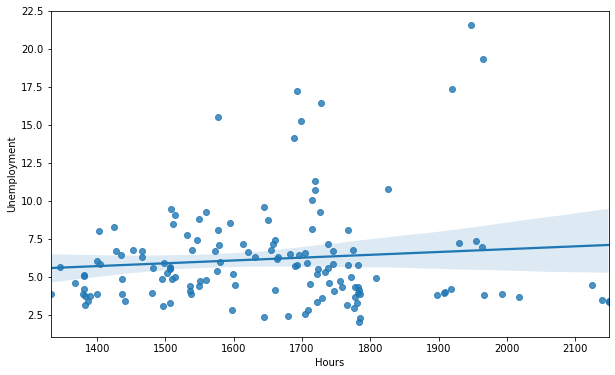

In [22]:
plt.figure(figsize=(10,6));
sb.regplot(data=df,x='Hours',y='Unemployment');

A very positive correlation between the unemployment rate and the number of working hours suggesting that as number of hours per employee increases the unemployment rate increases as well.

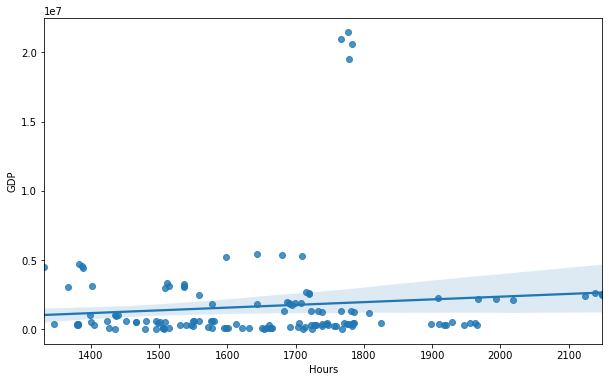

In [23]:
plt.figure(figsize=(10,6));
sb.regplot(data=df,y='GDP',x='Hours');

the working hours has a positive correlation with the GDP despite having a negative one with the unemployment rate but we can here notice that US is also a major outlier here with a moderate working hours so let's take a look at the distribution of working hours by countries.

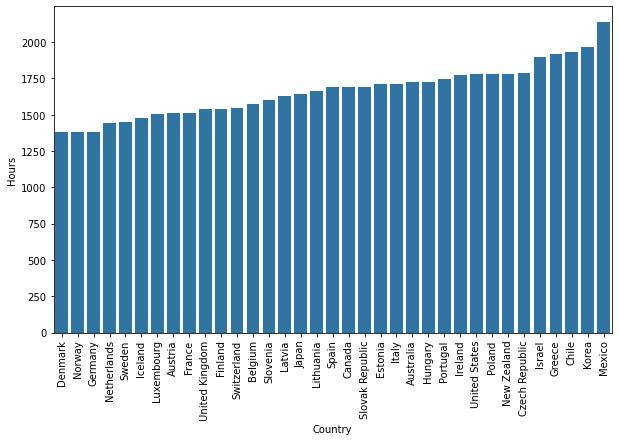

In [24]:
x = df.query('Year ==2019');
plt.figure(figsize=(10,6));
sb.barplot(data=x,x='Country',y='Hours',order=x.sort_values('Hours').Country,color=base_color);
plt.xticks(rotation=90);

Here we can see some very interesting insights, cause Greece with the highest unemployment rate and a very low GDP is the 4th most country with yearly working hours as well as Mexico being the most country with working hours with an okay GDP and a low unemployment rate.

Now we can say that really the working hours aren't the main factor affecting the productivity or increasing the GDP for countries, now let's look if it has an effect on the average wage of employees!

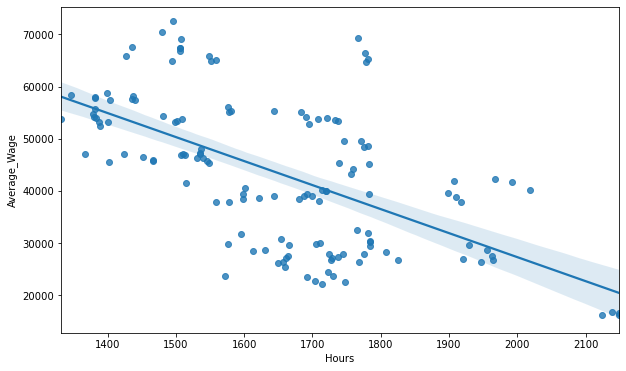

In [25]:
plt.figure(figsize=(10,6));
sb.regplot(data=df,y='Average_Wage',x='Hours');

We can now see very clearly that average wage has a negative correlation with the yearly working hours with the highest averages lie between low to moderate number of hours!! now let's check the relationship between the wages and the GDP

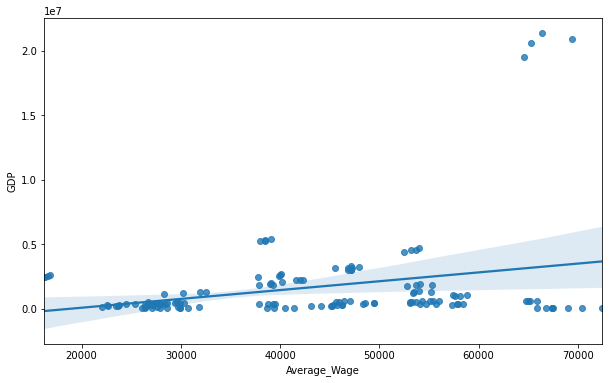

In [26]:
plt.figure(figsize=(10,6));
sb.regplot(data=df,y='GDP',x='Average_Wage');

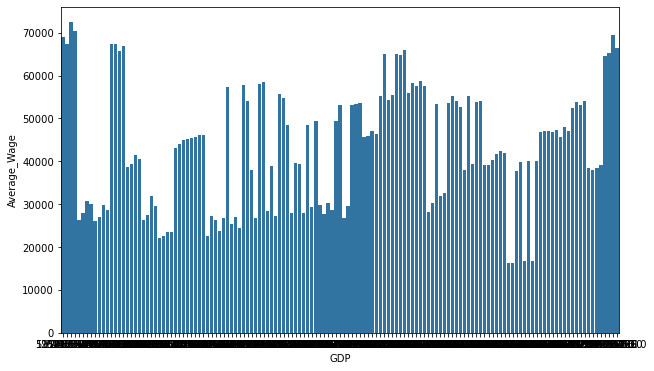

In [27]:
plt.figure(figsize=(10,6));
sb.barplot(data=df,x='GDP',y='Average_Wage',color=base_color);

Here we can also see a very strange pattern where the Lowest and the highest GDP pay the highest average wages with the lowest average wage coming near or after the third quartile!

But has it always been like that? 
Now let's take a look at these factors across the years

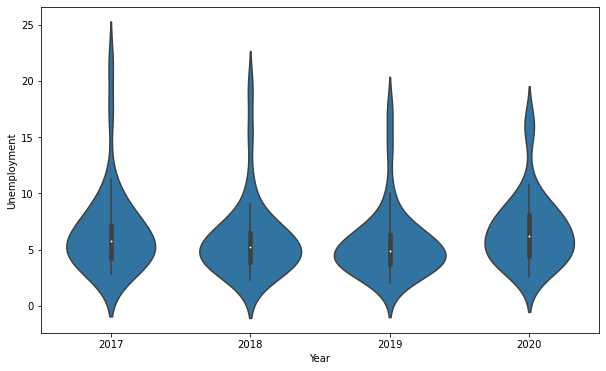

In [28]:
plt.figure(figsize=(10,6));
sb.violinplot(data=df,x='Year',y='Unemployment',inner='box',color=base_color)

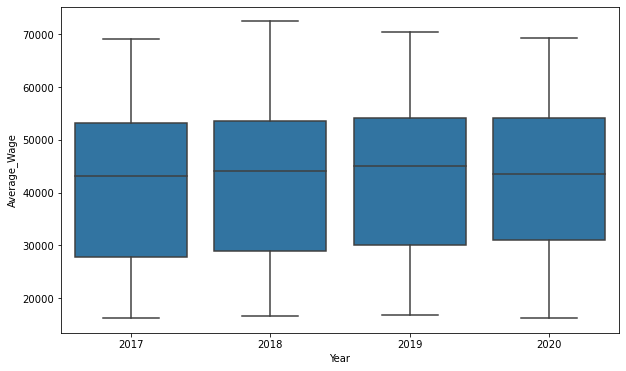

In [29]:
plt.figure(figsize=(10,6));
sb.boxplot(data=df,x='Year',y='Average_Wage',color=base_color)

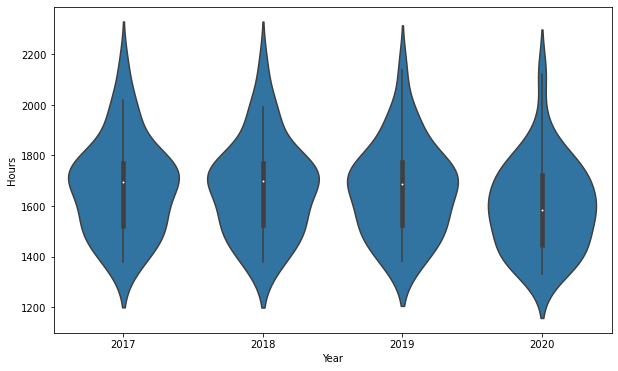

In [30]:
plt.figure(figsize=(10,6));
sb.violinplot(data=df,x='Year',y='Hours',color=base_color)

We can see that the differences across the last 3 years are not that big when it comes to both unemployment rates, average wages and working hours but for 2020 the difference can be noticed as there was a steep increase in wages and decrease in unemployment  but changed as well as a decrease in working hours surely due to the covid-19 pandemic.

C:\Users\Ahmed\anaconda3\lib\site-packages\seaborn\axisgrid.py:723: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


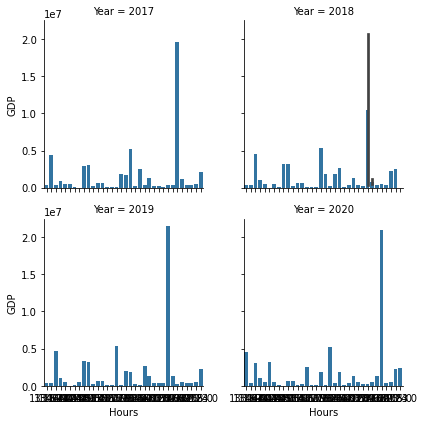

In [31]:
g = sb.FacetGrid(data=df,col='Year',col_wrap=2)
g.map(sb.barplot,'Hours','GDP');

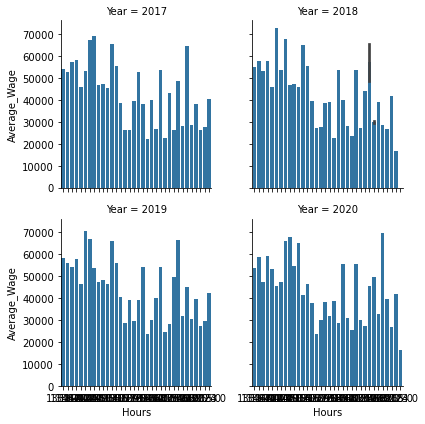

In [32]:
g = sb.FacetGrid(data=df,col='Year',col_wrap=2)
g.map(sb.barplot,'Hours','Average_Wage');

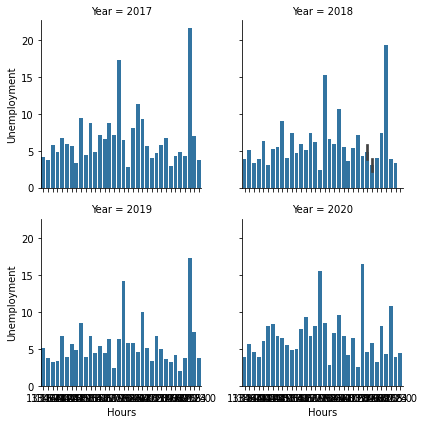

In [33]:
g = sb.FacetGrid(data=df,col='Year',col_wrap=2)
g.map(sb.barplot,'Hours','Unemployment');

# CONCLUSIONS

1 - We have seen the relationship between working hours,GDP,average wages and unemployment rate which shows that the working hours don't really affect the GDP that much but they affect the average wages negatively as well as affecting the unemployment rates by raising them significantly, which shows that poorer countries have a very high working hours with very low wages while others have the biggest share of the wages, employing less, giving more workload to employers while paying them less. 

2 - The highest average wages were associated with a moderate to low number of working hours which suggests that overload in work actually harms the worker as with higher working hours the wages are lower, not contributing much to the GDP nor being very productive. 

The three figures up there showing the relationship between the hours and different aspects over the last 4 years assure our conclusions as we can see clearly that : 

    1- The highest GDP isn't associated with the highest working hours rather it's better when the working hours are moderate.
    
    2- The highest wages weren't for the people with the most working hours but also at a moderate working hours.
    
    3- The unemployment rate was much higher when the working hours increased showing the negative effects it can have on both economy and employee as the working hours increase.